## Loading the Data set:


In [1]:
import pandas as pd
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pickle
import matplotlib.pyplot as plt

<b>Defining the different flairs that will be available.</b>

In [2]:
flairs = ["AskIndia", "Non-Political","Scheduled", "Photography", "Science/Technology",
        "Politics", "Business/Finance", "Policy/Economy", "Sports", "Food"]

In [3]:
data = pd.read_csv('f_300_clean.csv')
data.fillna("",inplace = True)

data.replace({'flair': {"AskIndia": 0, "Non-Political": 1,
                      "Scheduled": 2, "Photography": 3,
                     "Science/Technology": 4, "Politics": 5,
                     "Business/Finance": 6, "Policy/Economy": 7,
                     "Sports": 8, "Food": 9 }}, inplace=True)

Y = data.flair
X = data.combined_features

print(X.head())
print(X.shape)

0    differ stage hair loss perfect order mumbai lo...
1    women gather dust storm rajasthan. nan. steve ...
2    zoom took shot night supermoon stack detail lu...
3    wild gaur nagarahol nation park. nan. wild pro...
4    puffi superdog zenfon. nan. nice have tree hou...
Name: combined_features, dtype: object
(2422,)


<b>
Splitting the data into Training and Testing for valuation of accuracy and validation</b>

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)
print(len(X_train))
print(len(X_test))

1937
485


<b>
    Initializing some essential variables.
    </b>
 

In [5]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

## Corpus Tokenization:
<br>
<b>
Now i Vectorized the training corpus, by turning each text into either a sequence of integers. The vocabulary size has been set to 5000 words.
    </b>

In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
dict(list(word_index.items())[1:10])

{'like': 2,
 'peopl': 3,
 'hai': 4,
 'india': 5,
 'http': 6,
 'time': 7,
 'good': 8,
 'delet': 9,
 'com': 10}

<b>
    Saving this tokenizer in a pickle file so that we can use this feature in the WebApp also.

In [7]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

<b>
Converting text to sequences using the Tokenizer.
    <br>
    Adding padding of 0 to each entry in the training data to make the maximum size uniform.
</b>

In [8]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#print(X_train[0])

<b>Prepareing the Test data also</b>

In [9]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

<b> Converting the Result Column of the dataframe into a numpy array

In [10]:
print(Y_train.head())
print(Y_test.head())
Y_train = np.asarray(Y_train)
Y_test = np.asarray(Y_test)

1606    9
1517    9
1848    5
1260    8
118     3
Name: flair, dtype: int64
613     0
1266    8
892     6
296     4
611     0
Name: flair, dtype: int64


## Defining a function which plots:
<b>
<br>
The Training and Validation Accuracy V/S number of Epoch
<br>
The Training and Validation Loss V/S number of Epoch
</b>

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Define the Sequential Model:
<br>
<b>
    After experimenting and evaluating various models and tuning their hyper parameters, i have selected this sequential model.

In [17]:
input_dim = X_train.shape[1]  # Number of features

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           320000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              65000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10010     
Total params: 395,010
Trainable params: 395,010
Non-trainable params: 0
_________________________________________________________________


<b>Fitting the model and also Saving the Weights in a h5 file for implementing in the WebApp.

In [18]:
num_epochs = 15
history = model.fit(X_train, Y_train, epochs=num_epochs, validation_data=(X_test, Y_test), verbose=True)

model.reset_metrics()
model.save('DL_Model.h5')

Train on 1937 samples, validate on 485 samples
Epoch 1/15
1937/1937 [==============================] - 1s 408us/sample - loss: 2.3030 - accuracy: 0.1033 - val_loss: 2.2929 - val_accuracy: 0.1052
Epoch 2/15
1937/1937 [==============================] - 1s 327us/sample - loss: 2.2334 - accuracy: 0.1704 - val_loss: 2.0894 - val_accuracy: 0.2103
Epoch 3/15
1937/1937 [==============================] - 1s 422us/sample - loss: 1.9026 - accuracy: 0.3335 - val_loss: 1.7814 - val_accuracy: 0.3876
Epoch 4/15
1937/1937 [==============================] - 1s 427us/sample - loss: 1.5492 - accuracy: 0.4760 - val_loss: 1.4755 - val_accuracy: 0.5052
Epoch 5/15
1937/1937 [==============================] - 1s 413us/sample - loss: 1.1261 - accuracy: 0.6531 - val_loss: 1.2305 - val_accuracy: 0.5938
Epoch 6/15
1937/1937 [==============================] - 1s 422us/sample - loss: 0.8180 - accuracy: 0.7506 - val_loss: 1.1278 - val_accuracy: 0.6103
Epoch 7/15
1937/1937 [==============================] - 1s 431us/

Training Accuracy: 0.9995
Testing Accuracy:  0.6454


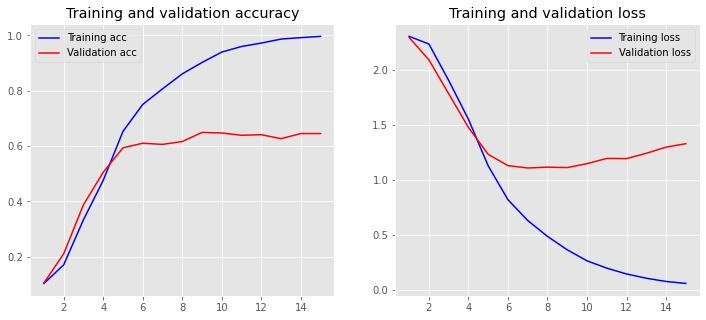

In [19]:
plot_history(history)
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))